# **Dataiku Data Scientist Technical Assessment**
### Author : Jules Boistard
### Submission date : January 18th, 2022
___

#### **#2 : Pre-processing**

The goal here is to iteratively find the best pre-processing pipeline based on a simple basic machine learning model, adding/removing steps along the way

##### #2.1 : Importing and splitting data

In [1]:
# Read the train and test files
# NB : we do not want instance weight for machine learning training
import pandas as pd

train = pd.read_csv("data/train_clean.csv", header=0)
test = pd.read_csv("data/test_clean.csv", header=0)
data = pd.concat([train, test], ignore_index=True)

# Split datasets into features set and target variable
# Note : target classes "-50k" and ">50k" will respectively be labelled 0 and 1
X_train = train.iloc[:, :-2]
X_test = test.iloc[:, :-2]
y_train = train.iloc[:, -2].map(lambda s: 0 if "-" in s else 1)
y_test = test.iloc[:, -2].map(lambda s: 0 if "-" in s else 1)

##### #2.2 : Basic pre-processing operations

To evaluate our pre-processing choices in this section, we will use a baseline Decision Tree model for comparison.

For our first basic preprocessing pipeline, we will :
- Drop columns with >40% NaN Values (migration related)
- Impute NaN values with most frequent class for other columns (country of birth, hispanic origin, state of previous residence)
- Use Ordinal Encoding for categorical features. The reason for not using one hot encoding for the time being is that we want to be able to identify meaningful features
- Use standard scaling to standardize our numerical features

In [2]:
# Let us first define different sets of features
base_num_cols = ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "num persons worked for employer", "weeks worked in year"]
base_cat_cols = [col for col in X_train.columns if col not in base_num_cols]

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class BinaryNumFeatureMapper(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff=0):
        self.cutoff=cutoff
        return None

    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        X2 = X.applymap(lambda val: 0 if val <= self.cutoff else 1)
        return X2




In [5]:
# Define evaluation procedure
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(clf, X_train, y_train, X_test, y_test, curves=True):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    if curves:
        N, train_score, val_score = learning_curve(clf, X_train, y_train, scoring="f1_weighted")
        plt.figure()
        plt.plot(N, train_score.mean(axis=1), label="train score")
        plt.plot(N, val_score.mean(axis=1), label="val score")
        plt.legend()


In [6]:
# Defining basic preprocessing steps
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cols_to_drop = ['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'migration prev res in sunbelt']
categorical_cols = [col for col in base_cat_cols if col not in cols_to_drop]
numerical_cols = [col for col in base_num_cols if col not in cols_to_drop]

categories = [data[col].unique() for col in categorical_cols]

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=categories))
])

num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("dropper", "drop", cols_to_drop),
    ("categorical", cat_transformer, categorical_cols),
    ("numerical", num_transformer, numerical_cols)
])

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     72669
           1       0.47      0.47      0.47      6157

    accuracy                           0.92     78826
   macro avg       0.71      0.71      0.71     78826
weighted avg       0.92      0.92      0.92     78826



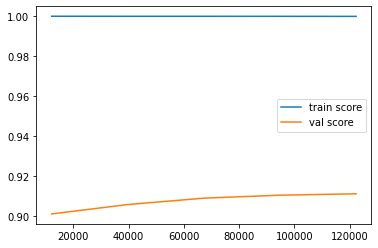

In [7]:
# Creating baseline decision tree model
from sklearn.tree import DecisionTreeClassifier
dt_classif = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])
evaluate_model(dt_classif,X_train, y_train, X_test, y_test)

- While the f1-score is not too bad on the major class (under 50k incomes), is it quite poor for the minor class (over 50k)
- From the curves, we can see that the model is clearly underfitting. We will therefore perform some feature engineering to adress this issue

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     72669
           1       0.23      0.61      0.34      6157

    accuracy                           0.81     78826
   macro avg       0.60      0.72      0.61     78826
weighted avg       0.91      0.81      0.85     78826



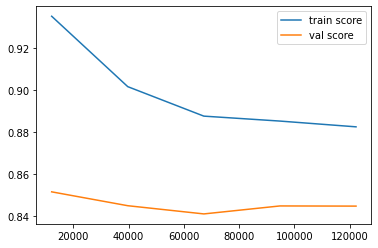

In [19]:
cols_to_keep = ["age", "weeks worked in year", "dividends from stocks", "education", "marital stat"]
categorical_cols2 = ["education", "marital stat"]
num_cols2 = ["age", "weeks worked in year", "dividends from stocks"]

categories2 = [data[col].unique() for col in categorical_cols2]

cat_transformer2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=categories2))
])

preprocessor2 = ColumnTransformer(transformers=[
    ("dropper", "drop", [col for col in X_train.columns if col not in cols_to_keep]),
    ("categorical", cat_transformer2, categorical_cols2),
    ("numerical", num_transformer, num_cols2)
])
dt_classif2 = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])
evaluate_model(dt_classif2, X_train, y_train, X_test, y_test)

##### #2.3 : Feature Engineering

In [171]:
feature_importance = pd.DataFrame(data=dt_classif["classifier"].feature_importances_, index=[col for col in X_train.columns if col not in cols_to_drop], columns=["coef"])
feature_importance.sort_values("coef", ascending=False).head(10)

,coef
marital stat,0.263873
country of birth self,0.137974
veterans benefits,0.085454
detailed occupation recode,0.056018
race,0.050706
own business or self employed,0.049719
year,0.048604
detailed industry recode,0.039547
class of worker,0.030206
weeks worked in year,0.026789


In [172]:
from sklearn.decomposition import PCA

dt_classif_with_pca = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=15)),
    ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])
evaluate_model(dt_classif_with_pca, X_train, y_train, X_test, y_test, curves=False)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     72669
           1       0.36      0.35      0.35      6157

    accuracy                           0.90     78826
   macro avg       0.65      0.65      0.65     78826
weighted avg       0.90      0.90      0.90     78826



In [163]:
dt_classif_with_fs["pca"].explained_variance_

array([244.2125024 , 117.66089513,  70.85683127,  50.17283633,
        18.30244674,  15.47858678,  13.16703592,  11.47516548,
         9.33411216,   5.45850675,   3.29744606,   2.52110743,
         1.99191078,   1.88207855,   1.57870633,   1.32694564,
         1.12406249,   1.05786782,   0.98935217,   0.85829592])

<AxesSubplot:>

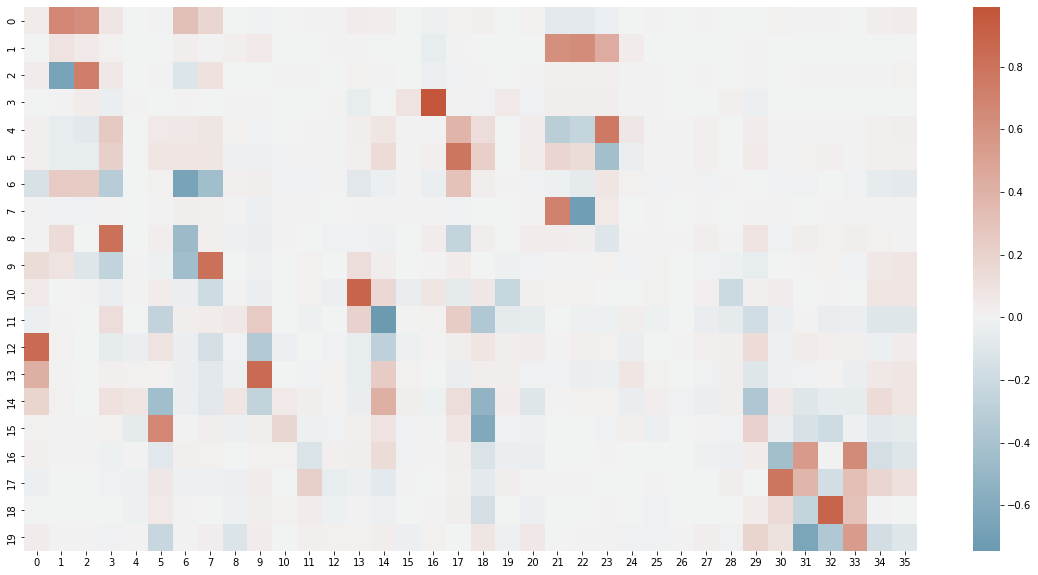

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.set_theme
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(dt_classif_with_fs["pca"].components_, cmap=cmap, center=0)

PCA does not work very well (not improving score, especially with low number of components)

##### #2.4 : Resampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

dt_classif_with_us = imPipeline(steps=[
    ("preprocessor", preprocessor),
    ("resample", SMOTE(random_state=42)),    
    ("classifier", DecisionTreeClassifier(random_state=42))
])
evaluate_model(dt_classif_with_us, X_train, y_train, X_test, y_test, curves=False)

##### #2.5 : More complex models

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     72669
           1       0.73      0.41      0.52      6157

    accuracy                           0.94     78826
   macro avg       0.84      0.70      0.75     78826
weighted avg       0.93      0.94      0.93     78826



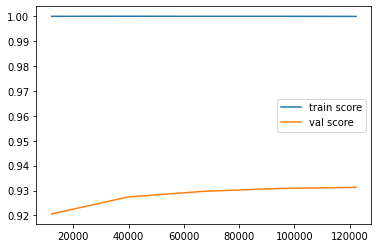

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_classif = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
])
evaluate_model(rf_classif, X_train, y_train, X_test, y_test, curves=True)

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     72669
           1       0.28      0.85      0.42      6157

    accuracy                           0.82     78826
   macro avg       0.63      0.83      0.66     78826
weighted avg       0.93      0.82      0.86     78826



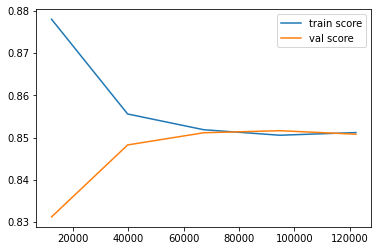

In [12]:
from sklearn.linear_model import LogisticRegression

lr_classif = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
])
evaluate_model(lr_classif, X_train, y_train, X_test, y_test, curves=True)